## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
import itertools

import parse

import napari

from skimage.measure import (regionprops, _regionprops)

from napari.utils.notebook_display import nbscreenshot

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_my_props_to_dict, _assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

from infer_subc.constants import (TEST_IMG_N,
                                    NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH ) 

import time
%load_ext autoreload
%autoreload 2

## Get and load image for quantification
Specifically, this will include the raw image and the outputs from segmentation.

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

raw_data_path = data_root_path / "raw"
im_type = ".czi"

raw_file_list = list_image_files(raw_data_path,im_type)
raw_img_name = raw_file_list[test_img_n]

# adding an additional list of image paths for the matching segmentation files
seg_data_path = data_root_path / "out"
seg_file_list = list_image_files(seg_data_path, "tiff")

# changing output directory for this notebook to a new folder called "quant"
out_data_path = data_root_path / "quant"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
# raw image
raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [4]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("20230426_test_nuc", raw_meta_dict, seg_data_path)
cell_seg = import_inferred_organelle("20230426_test_cell", raw_meta_dict, seg_data_path)
cyto_seg = import_inferred_organelle("20230426_test_cyto", raw_meta_dict, seg_data_path)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path)

#organelles
lyso_seg = import_inferred_organelle("20230426_test_lyso", raw_meta_dict, seg_data_path)
mito_seg = import_inferred_organelle("20230426_test_mito", raw_meta_dict, seg_data_path)
golgi_seg = import_inferred_organelle("20230426_test_golgi", raw_meta_dict, seg_data_path)
perox_seg = import_inferred_organelle("20230426_test_perox", raw_meta_dict, seg_data_path)
ER_seg = import_inferred_organelle("20230426_test_ER", raw_meta_dict, seg_data_path)
LD_seg = import_inferred_organelle("20230426_test_LD", raw_meta_dict, seg_data_path)


loaded  inferred 3D `20230426_test_nuc`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cell`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cyto`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_lyso`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_mito`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_golgi`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_perox`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_ER`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_LD`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 


-----------------
## **DISTRIBUTION**  

We will be measuring the distribution of **organelles** and **contact sites** in XY and in Z, separately. We have defined a function for each type of distribution below.  

### XY Distribution 

Here we are refering to the XY distribution as the spread of organelles from the nucleus out to the cell membrane. This is similar to the calculations done in CellProfiler: https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.5/modules/measurement.html?highlight=distribution#module-cellprofiler.modules.measureobjectintensitydistribution". 

Our pipeline in brief:
1. Make a sum projection across the z axis of the cell mask and nucleus mask, and any organelles/objects you will want to measure the distribution of.
2. Concentric rings are created out from the edge of the nucleus to the edge of the cell membrane; they are scaled to the size and shape of the cell and nucleus. Visualizations of this are included below.
3. Each ring is consider a bin wherein the total amount of each object is measured.

Included measurements:
- {amount per ring, but need to be more specific here}
- Zernike magnitude and phase within each ring (distribution radially in each ring)

The logic of this function was based on what is implimented in CellProfiler. Here we utilize segmentation outputs instead of intensity images as was intended in the CellProfiler function. The sum projection in step 1 above allows us to add together the number of True or 1 values within each XY position of the image. This number is then used to summarize the organelle distribution from the entire cell with respect to only XY. We have also simplified the function to perform analysis on just a single cell; multi-cell analysis has not been implimented in this package at all. 


#### `notes from Andy below - may not need all of these in the final version`


##### 2D projection of inferred objects (and masks, florescence image)

Segment image in 3D;
sum projection of binary image; 
create 5 concentric rings going from the edge of the nuclie to the edge of the cellmask (ideally these will be morphed to cellmask/nuclei shape as done in CellProfiler); 
measure intensity per ring (include nuclei as the center area to measure from)/ring area; 
the normalized measurement will act as a frequency distribution of that organelle starting from the nuclei bin going out to the cell membrane - 
Measurements needed: mean, median, and standard deviation of the frequency will be calculated

- pre-processing
  1. Make 2D sum projection of binary segmentation
  2. Create 5 (default) bins linearly between edge of the nuclei to the edge of the cellmask - these are somewhat like rings morphed to the shape of the nuclei and cellmask, or more accurately like terrain lines of the normalized radial distance beween teh edge of the nuclei and the edge of the cellmask.
  3. Use nucleus + concentric rings to mask the 2D sum project into radial distribution regions: nuclei = bin 1, ... largest/outter most ring = bin 6. See similar concept in CellProfiler: https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.5/modules/measurement.html?highlight=distribution#module-cellprofiler.modules.measureobjectintensitydistribution"	
   


The logic was borrowed from CellProfiler, but alorithm somewhate simplified by making assumpitions of doing all estimates over a single cellmask (single cell).   Most of the code should be capable of performing the more complicated multi-object versions as CellProfiler does.  Although this functionality is untested the source code was left in this more complex format in case it might be updated for this functionality in the future.



##### Zernicky distributions...
- get the magnitude and phase for the zernike 
- he Zernike features characterize the distribution of intensity across the object. For instance, Zernike 1,1 has a high value if the intensity is low on one side of the object and high on the other. The zernike magnitudes feature records the rotationally invariant degree magnitude of the moment and the zernike phase feature gives the moment’s orientation

`zernike_degree` (default = 9) chooses how many moments to calculate.


The logic was borrowed from CellProfiler, but alorithm greatly simplified by making assumpitions of doing all estimates over a single cellmask (single cell)


## `code starts (delete above after removing andy's notes as needed)`

### 1. Create sum projection of the segmentation outputs

We will create a sum projection of the cell mask, nucleus, and each organelle we want to measure the distribution of.

#### 1a. Create sum projections

In [6]:
viewer= napari.Viewer()

In [7]:
# cell mask projection - summation of entire cell area in one XY plane
test_cell_proj = cell_seg.astype(bool).sum(axis=0)

# nucleus projection - summation of entire nucleus in one XY plane
nuc_masked = apply_mask(nuc_seg.astype(bool), cell_seg.astype(bool))
test_nuc_proj = nuc_masked.sum(axis=0)

# test organelle projection  - summation of entire golgi area in one XY plane
golgi_masked = apply_mask(golgi_seg.astype(bool), cell_seg.astype(bool))
test_golgi_proj = golgi_masked.sum(axis=0)

In [10]:
viewer.add_image(test_cell_proj, colormap="gray")
viewer.add_image(test_nuc_proj, colormap="blue")
viewer.add_image(test_golgi_proj, colormap="yellow")
viewer.grid.enabled = True

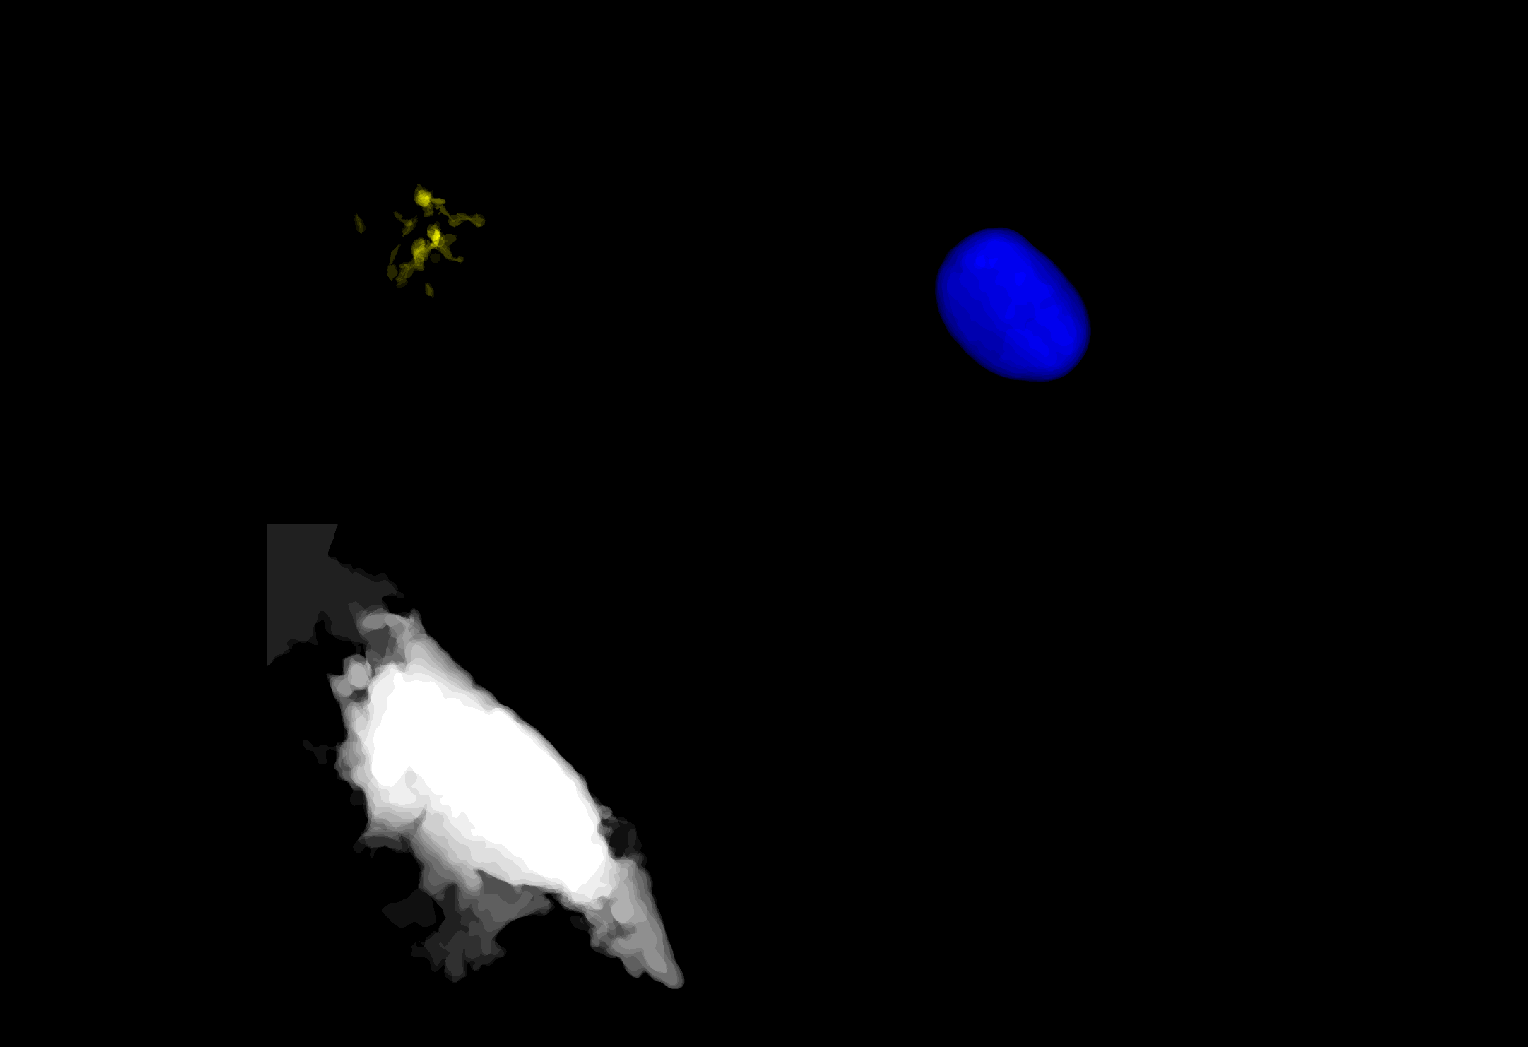

In [11]:
nbscreenshot(viewer, canvas_only=True)

In [12]:
viewer.close()

#### Define `create_masked_sum_projection`

Based on the prototyping above, define the function to apply a mask and create a sum projection

In [13]:
def _create_masked_sum_projection(img_in:np.ndarray, mask:Union[np.ndarray, None]=None, to_bool:bool=True) -> np.ndarray:
    """
    
    """
    img_out = img_in.astype(bool) if to_bool else img_in
    if mask is not None:
        img_out = apply_mask(img_out, mask)
    
    return img_out.sum(axis=0)

In [14]:
test_cell_proj_a = _create_masked_sum_projection(cell_seg)
test_nuc_proj_a = _create_masked_sum_projection(nuc_seg, cell_seg.astype(bool))
test_golgi_proj_a = _create_masked_sum_projection(golgi_seg, cell_seg.astype(bool))

In [15]:
np.array_equal(test_cell_proj, test_cell_proj_a), np.array_equal(test_nuc_proj, test_nuc_proj_a), np.array_equal(test_golgi_proj, test_golgi_proj_a)

(True, True, True)

#### Add function to `stats.py`

In [16]:
from infer_subc.utils.stats import create_masked_sum_projection

test_cell_proj_final = create_masked_sum_projection(cell_seg)

np.array_equal(test_cell_proj, test_cell_proj_final)

True

### 2. Utilize centrosome to create the concentric rings out from the nucleus to the edge of the cell mask

In [19]:
viewer = napari.Viewer()

#### 2a. Create a representation of pixels within the cell mask based on how far they are from the edge of the cell mask

radial_stats, radial_bin_mask = get_radial_distribution(cellmask_proj=cellmask_proj, #test_cell_proj_a
                                                            org_proj=org_proj, #test_golgi_proj_a
                                                            img_proj=img_proj, # removing this
                                                            org_name=organelle_name, # str
                                                            nucleus_proj=nucleus_proj, #test_nuc_proj_a
                                                            n_bins=n_rad_bins #int
                                                            )

In [17]:
# create binary images of the outer bound (cell) and centering object (nucleus) to create the concentric rings from
test_center_objects = test_nuc_proj_a>0
test_labels = (test_cell_proj_a>0).astype(np.uint16)

normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(labels, #test_labels
                                                                                      center_objects, #test_center_object
                                                                                      center_on_nuc, #False
                                                                                      keep_nuc_bins) #True
    

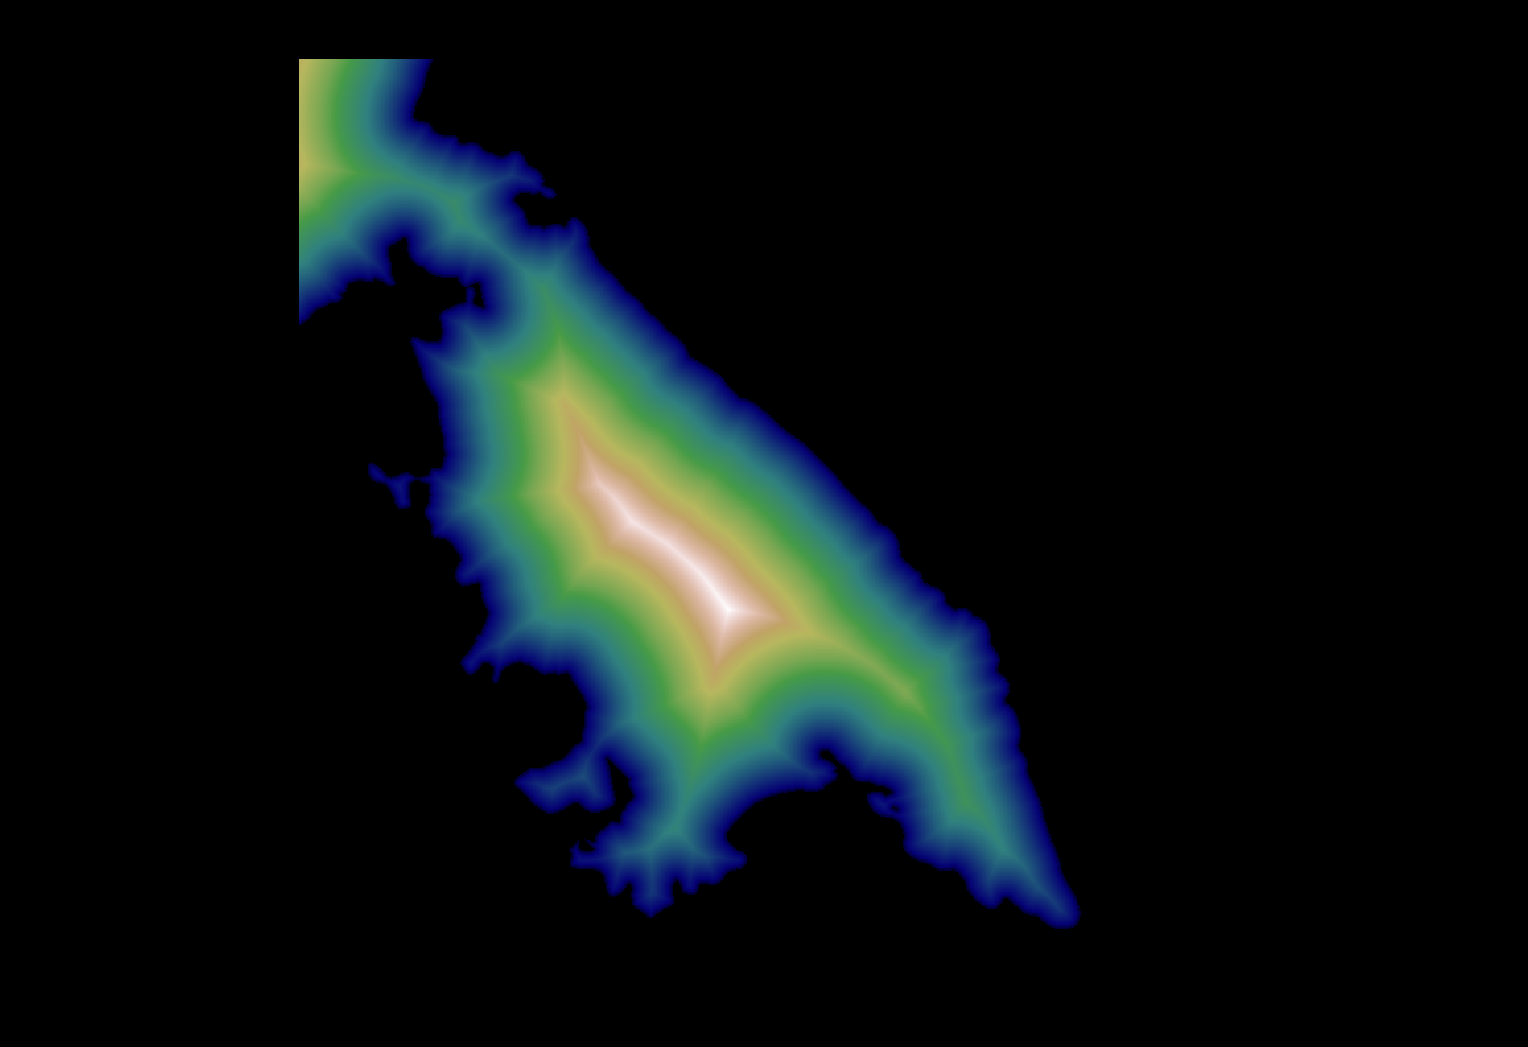

In [20]:
# apply a euclidian distance transform for the cellmask projection; brightness represents the distance from the edge of the cell
test_d_to_edge = centrosome.cpmorphology.distance_to_edge(test_labels)
viewer.add_image(test_d_to_edge*255, colormap='gist_earth')
nbscreenshot(viewer, canvas_only=True)

#### 2b. Create a representation of pixels within the cell mask based on how far they are from the center of our "centering object". Here we are using the nucleus, but the center of the cell mask could also work.

In [21]:
# this lists the pixel counts for each cell mask in the image
test_center_labels = label(test_center_objects)
test_pixel_counts = centrosome.cpmorphology.fixup_scipy_ndimage_result(ndi_sum(np.ones(test_center_labels.shape), 
                                                                               test_center_labels, 
                                                                               np.arange(1, np.max(test_center_labels) + 1, dtype=np.int32),
                                                                               ))
test_good = test_pixel_counts > 0

# list the XY coordinates (i,j) of the center of the centering object (nucleus in our case)
test_i, test_j = (centrosome.cpmorphology.centers_of_labels(test_center_labels) + 0.5).astype(int)

test_ig = test_i[test_good]
test_jg = test_j[test_good]

test_lg = np.arange(1, len(test_i) + 1)[test_good]

In [22]:
# Reduce the propagation labels to the centers of the centering objects (nucleus); True = use center of centering to start bin creation; False = use edge of centering object to propogate bins out
test_center_on_nuc = False 

if test_center_on_nuc:
    test_center_labels = np.zeros(test_center_labels.shape, int)
    test_center_labels[test_ig, test_jg] = test_lg

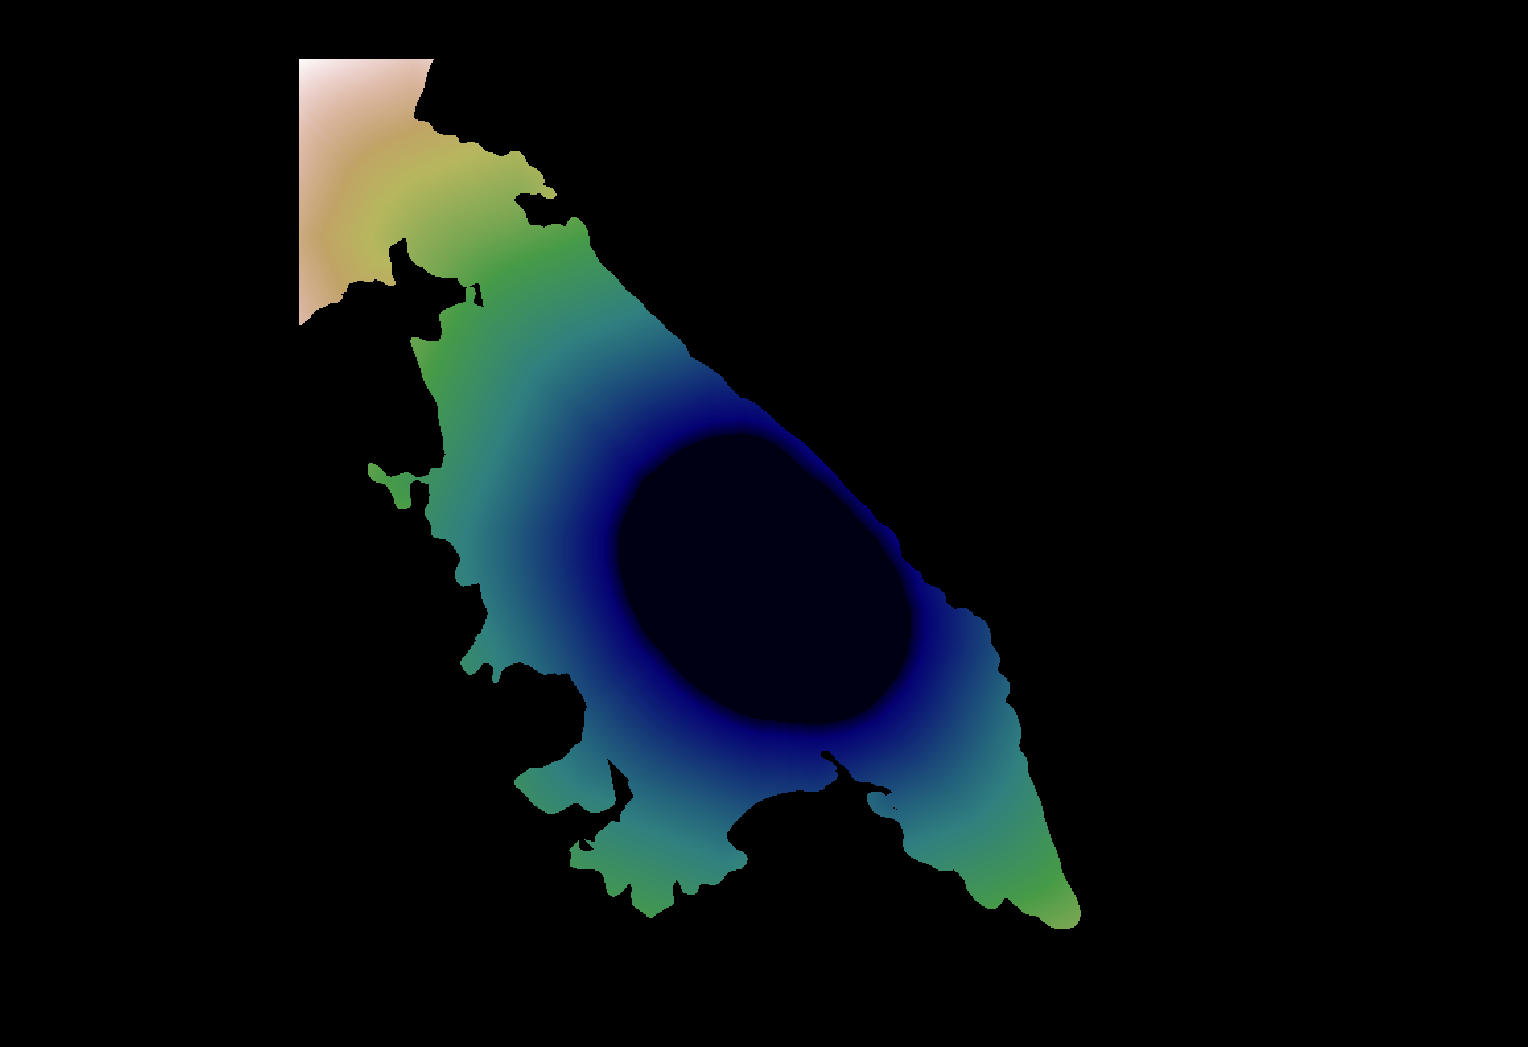

In [24]:
# propogates distances out from the center of the nucleus; brightest pixels are furthest away from nucleus
test_cl, test_d_from_center = centrosome.propagate.propagate(np.zeros(test_center_labels.shape), test_center_labels, test_labels != 0, 1)
test_cl[test_labels == 0] = 0 # apply the mask 

viewer.add_image(test_cl)
viewer.add_image(test_d_from_center, colormap='gist_earth')
nbscreenshot(viewer, canvas_only=True)

#### 2c. Make sure that each cell mask has a centering object and create a final projection cell mask that will be used downstream.

In [25]:
# test for missing nucleus within the cell mask; most important when there are more than one object (cell) in the image
test_missing_mask = (test_labels != 0) & (test_cl == 0)
test_missing_labels = np.unique(test_labels[test_missing_mask])

if len(test_missing_labels):
            print("WTF!!  how did we have missing labels?")
            test_all_centers = centrosome.cpmorphology.centers_of_labels(test_labels)
            test_missing_i_centers, test_missing_j_centers = test_all_centers[:, test_missing_labels-1]
            test_di = test_missing_i_centers[:, np.newaxis] - test_ig[np.newaxis, :]
            test_dj = test_missing_j_centers[:, np.newaxis] - test_jg[np.newaxis, :]
            test_missing_best = test_lg[np.argsort(test_di * test_di + test_dj * test_dj)[:, 0]]
            test_best = np.zeros(np.max(test_labels) + 1, int)
            test_best[test_missing_labels] = test_missing_best
            test_cl[test_missing_mask] = test_best[test_labels[test_missing_mask]]

            # Now compute the crow-flies distance to the centers of these pixels from whatever center was assigned to the object.
            test_iii, test_jjj = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]]
            test_di = test_iii[test_missing_mask] - test_i[test_cl[test_missing_mask] - 1]
            test_dj = test_jjj[test_missing_mask] - test_j[test_cl[test_missing_mask] - 1]
            test_d_from_center[test_missing_mask] = np.sqrt(test_di * test_di + test_dj * test_dj)

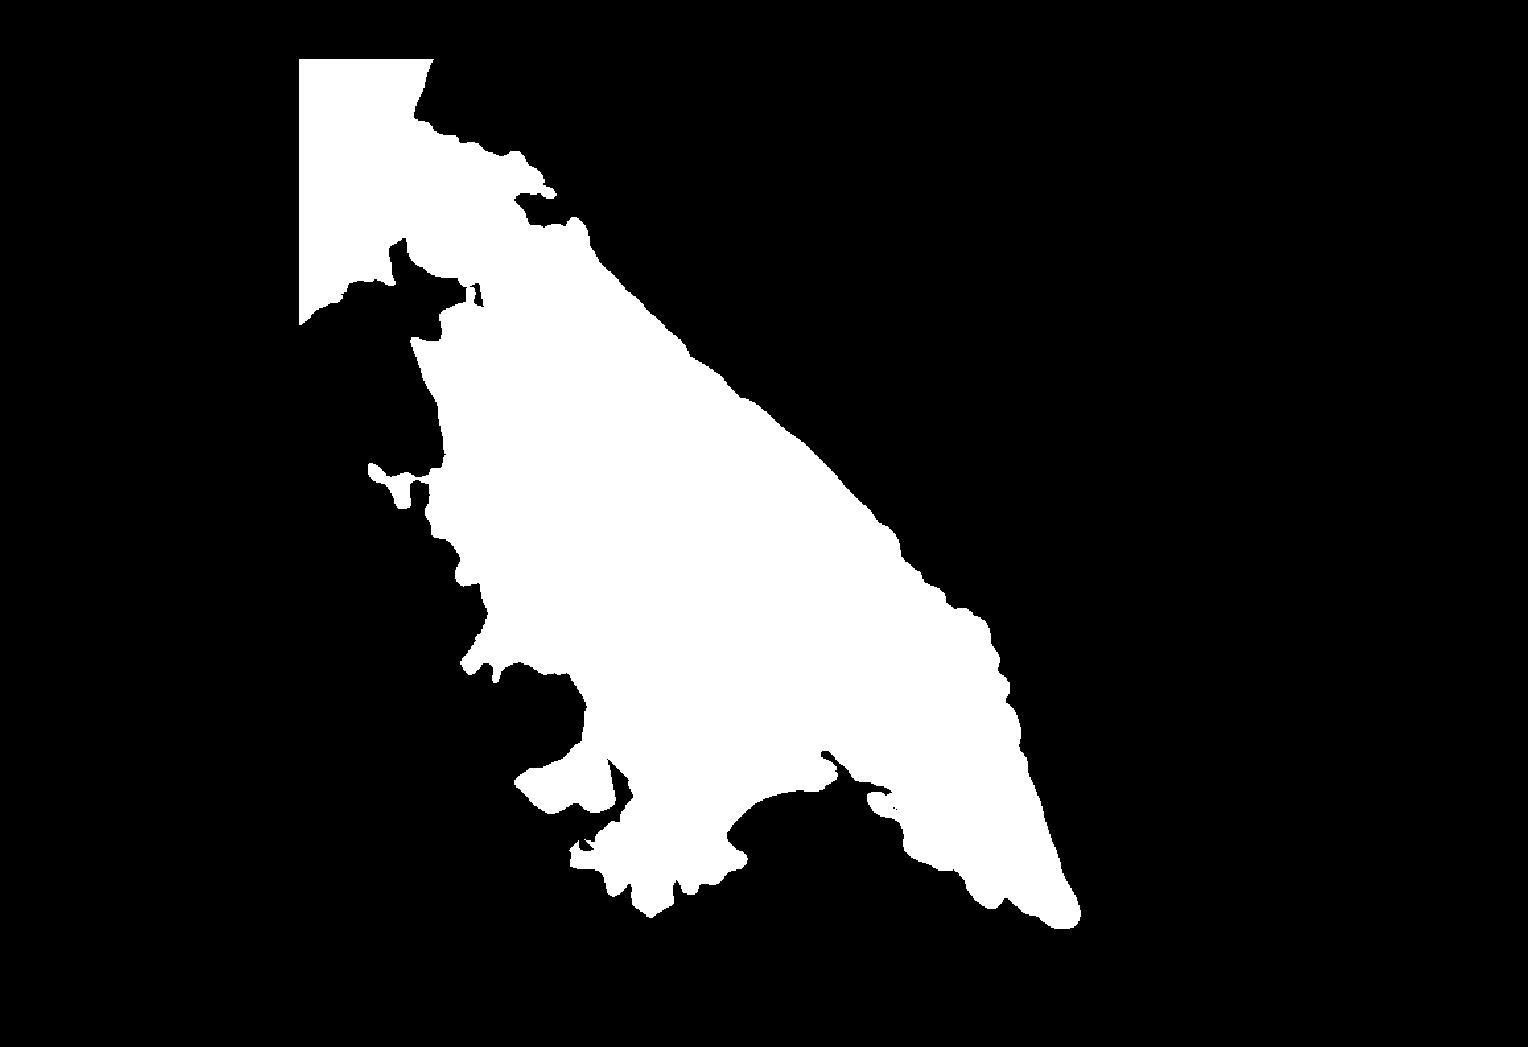

In [26]:
# create the projection cell mask that appropriately includes a centering cell mask
test_good_mask = test_cl > 0

viewer.add_image(test_good_mask)
nbscreenshot(viewer, canvas_only=True)

#### 2d. Decide how the cell area should be separated into bins (including or exclusing the centering object) and combining the two representations created above to produce one normalized representation of the distance between the centering object and the edge of the cell mask.

In [27]:
# Deciding if the nucleus (our centering object) will be the first bin or not if it will be excluded 
# In our case, "stuff" may lie above or below the nucleus in 3D which will appear within the nucleus area after sum projection
# False = do not include the nucleus as the first bin
test_keep_nuc_bins = True

if not test_keep_nuc_bins:
    # include pixels within the centering objects
    # when performing calculations from the centers
    test_good_mask = test_good_mask & (test_center_labels == 0)

In [28]:
# creating an object equal to the cellmask_proj with all pixel values equal to the X coordinate value (here called 'i')
test_i_center = np.zeros(test_cl.shape)
test_i_center[test_good_mask] = test_i[test_cl[test_good_mask] - 1]

# creating an object equal to the cellmask_proj with all pixel values equal to the Y coordinate value (here called 'j')
test_j_center = np.zeros(test_cl.shape)
test_j_center[test_good_mask] = test_j[test_cl[test_good_mask] - 1]

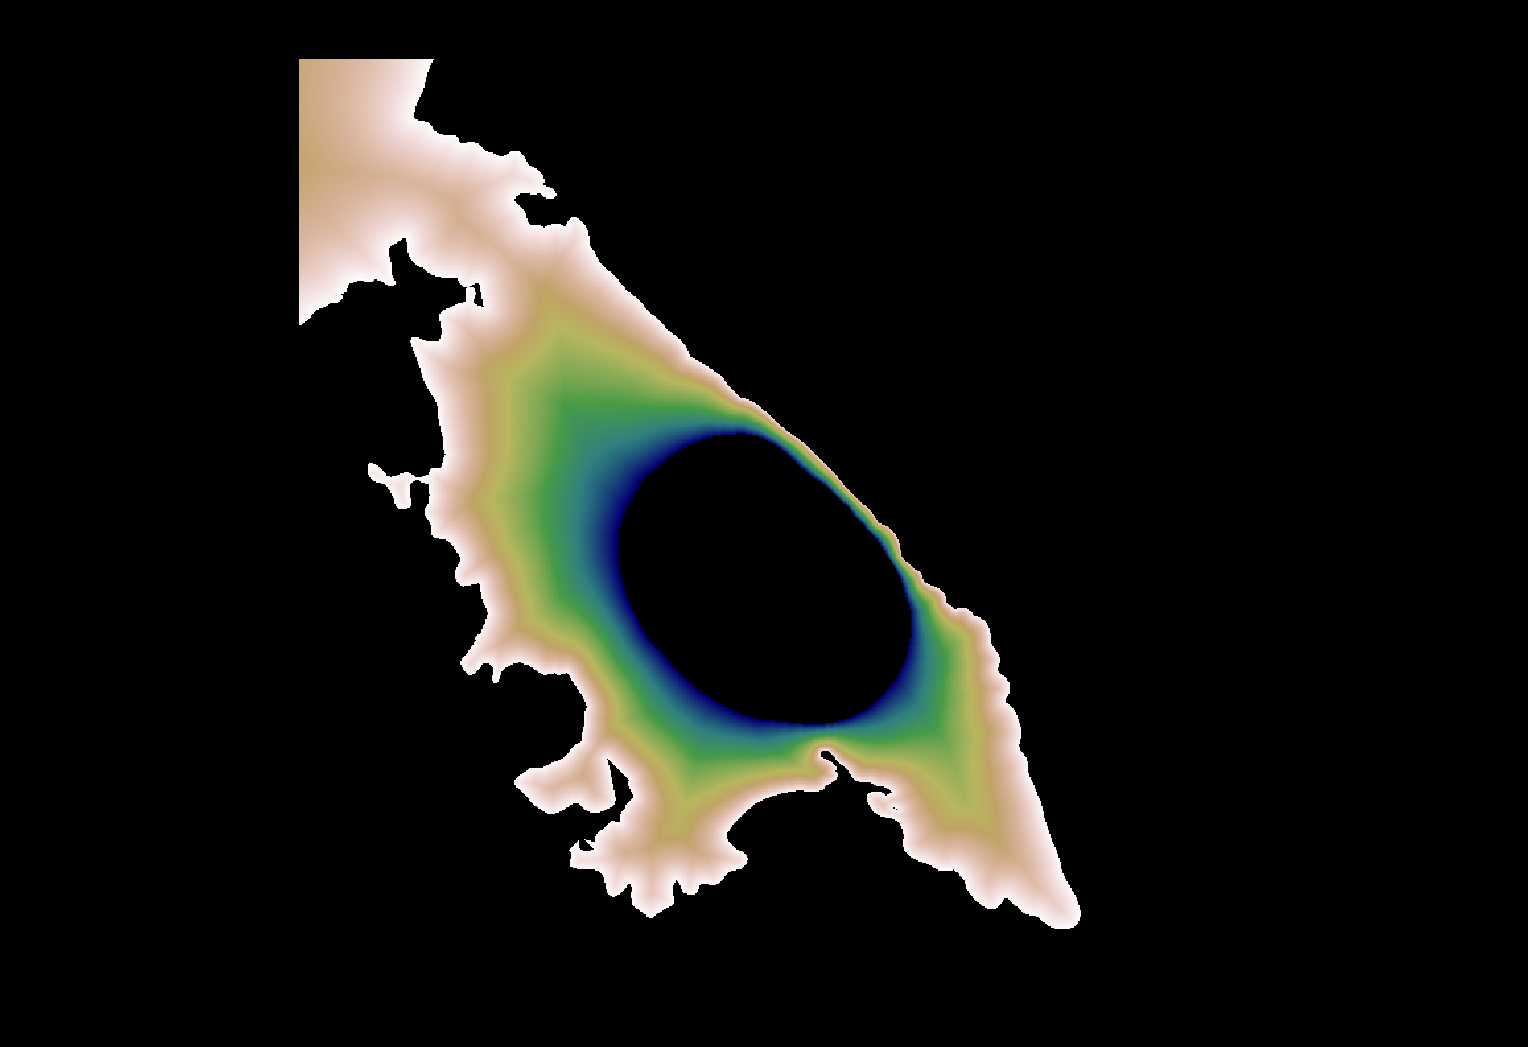

In [30]:
# creating normalized radial distance out from nucleus to edge of cell
test_normalized_distance = np.zeros(test_labels.shape) # creat an empty array
test_total_distance = test_d_from_center + test_d_to_edge # add the two distance arrays together
test_normalized_distance[test_good_mask] = test_d_from_center[test_good_mask] / ( test_total_distance[test_good_mask] + 0.001 )

viewer.add_image(test_normalized_distance, colormap='gist_earth')
nbscreenshot(viewer, canvas_only=True)

#### Define `get_normalized_distance_and_mask()` function.

Combine all of the above code into a function to define the normalized distances from the centering object to the edge of the cell mask and create a final projection cell mask to use downstream.

In [ ]:
def _get_normalized_distance_and_mask(labels, center_objects, center_on_nuc, keep_nuc_bins):
    """
    helper for radial distribution
    """
    d_to_edge = centrosome.cpmorphology.distance_to_edge(labels) # made a local version
    ## use the nucleus as the center 
    if center_objects is not None:
        # don't need to do this size_similarity trick.  I KNOW that labels and center_objects are the same size
        # center_labels, cmask = size_similarly(labels, center_objects)
        # going to leave them as labels, so in principle the same code could work for partitioned masks (labels)
        center_labels = label(center_objects)
        pixel_counts = centrosome.cpmorphology.fixup_scipy_ndimage_result(
                            ndi_sum(
                                np.ones(center_labels.shape),
                                center_labels,
                                np.arange(
                                    1, np.max(center_labels) + 1, dtype=np.int32
                                ),
                            )
                        )
        good = pixel_counts > 0
        i, j = ( centrosome.cpmorphology.centers_of_labels(center_labels) + 0.5).astype(int)
        ig = i[good]
        jg = j[good]
        lg = np.arange(1, len(i) + 1)[good]
        
        if center_on_nuc:  # Reduce the propagation labels to the centers of the centering objects
            center_labels = np.zeros(center_labels.shape, int)
            center_labels[ig, jg] = lg


        cl, d_from_center = centrosome.propagate.propagate(  np.zeros(center_labels.shape), center_labels, labels != 0, 1)
        cl[labels == 0] = 0            # Erase the centers that fall outside of labels


        # SHOULD NEVER NEED THIS because we arent' looking at multiple
        # If objects are hollow or crescent-shaped, there may be objects without center labels. As a backup, find the
        # center that is the closest to the center of mass.
        missing_mask = (labels != 0) & (cl == 0)
        missing_labels = np.unique(labels[missing_mask])
        
        if len(missing_labels):
            print("WTF!!  how did we have missing labels?")
            all_centers = centrosome.cpmorphology.centers_of_labels(labels)
            missing_i_centers, missing_j_centers = all_centers[:, missing_labels-1]
            di = missing_i_centers[:, np.newaxis] - ig[np.newaxis, :]
            dj = missing_j_centers[:, np.newaxis] - jg[np.newaxis, :]
            missing_best = lg[np.argsort(di * di + dj * dj)[:, 0]]
            best = np.zeros(np.max(labels) + 1, int)
            best[missing_labels] = missing_best
            cl[missing_mask] = best[labels[missing_mask]]

            # Now compute the crow-flies distance to the centers of these pixels from whatever center was assigned to the object.
            iii, jjj = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]
            di = iii[missing_mask] - i[cl[missing_mask] - 1]
            dj = jjj[missing_mask] - j[cl[missing_mask] - 1]
            d_from_center[missing_mask] = np.sqrt(di * di + dj * dj)

        good_mask = cl > 0

        if not keep_nuc_bins:
            # include pixels within the centering objects
            # when performing calculations from the centers
            good_mask = good_mask & (center_labels == 0)
            
    else: # ELSE     if center_objects is  None so center on the middle of the cellmask_mask
        i, j = centrosome.cpmorphology.maximum_position_of_labels(   d_to_edge, labels, [1])
        center_labels = np.zeros(labels.shape, int)
        center_labels[i, j] = labels[i, j]
        # Use the coloring trick here to process touching objectsin separate operations
        colors = centrosome.cpmorphology.color_labels(labels)
        ncolors = np.max(colors)
        d_from_center = np.zeros(labels.shape)
        cl = np.zeros(labels.shape, int)

        for color in range(1, ncolors + 1):
            mask = colors == color
            l, d = centrosome.propagate.propagate( np.zeros(center_labels.shape), center_labels, mask, 1)
            d_from_center[mask] = d[mask]
            cl[mask] = l[mask]

        good_mask = cl > 0

    ## define spatial distribution from masks
    # collect arrays of centers
    i_center = np.zeros(cl.shape)
    i_center[good_mask] = i[cl[good_mask] - 1]
    j_center = np.zeros(cl.shape)
    j_center[good_mask] = j[cl[good_mask] - 1]

    normalized_distance = np.zeros(labels.shape)
    total_distance = d_from_center + d_to_edge

    normalized_distance[good_mask] = d_from_center[good_mask] / ( total_distance[good_mask] + 0.001 )
    return normalized_distance, good_mask, i_center, j_center

In [ ]:
test_normalized_distance_a, test_good_mask_a, test_i_center_a, test_j_center_a = _get_normalized_distance_and_mask(labels=test_labels,
                                                                                                                  center_objects=test_center_objects,
                                                                                                                  center_on_nuc=False,
                                                                                                                  keep_nuc_bins=True)

In [ ]:
np.array_equal(test_normalized_distance, test_normalized_distance_a), np.array_equal(test_good_mask, test_good_mask_a), np.array_equal(test_i_center, test_i_center_a), np.array_equal(test_j_center, test_j_center_a)

(True, True, True, True)

#### Add prototype function into `stats.py`

In [ ]:
from infer_subc.utils.stats import get_normalized_distance_and_mask

test_normalized_distance_final, test_good_mask_final, test_i_center_final, test_j_center_final = _get_normalized_distance_and_mask(labels=test_labels,
                                                                                                                  center_objects=test_center_objects,
                                                                                                                  center_on_nuc=False,
                                                                                                                  keep_nuc_bins=True)

np.array_equal(test_normalized_distance, test_normalized_distance_final), np.array_equal(test_good_mask, test_good_mask_final), np.array_equal(test_i_center, test_i_center_final), np.array_equal(test_j_center, test_j_center_final)

(True, True, True, True)

### 3. Create concentric rings based on the normalized distance image created above and collect measurements of organelle distribution within those rings. 

The rings will be our "bins" to measure from.

#### 3a. Create a specified number of concentric rings from the normalized distances created above.

In [32]:
# we want 5 total bins
test_bin_count = 5 

test_ngood_pixels = np.sum(test_good_mask)
test_good_labels = test_labels[test_good_mask]

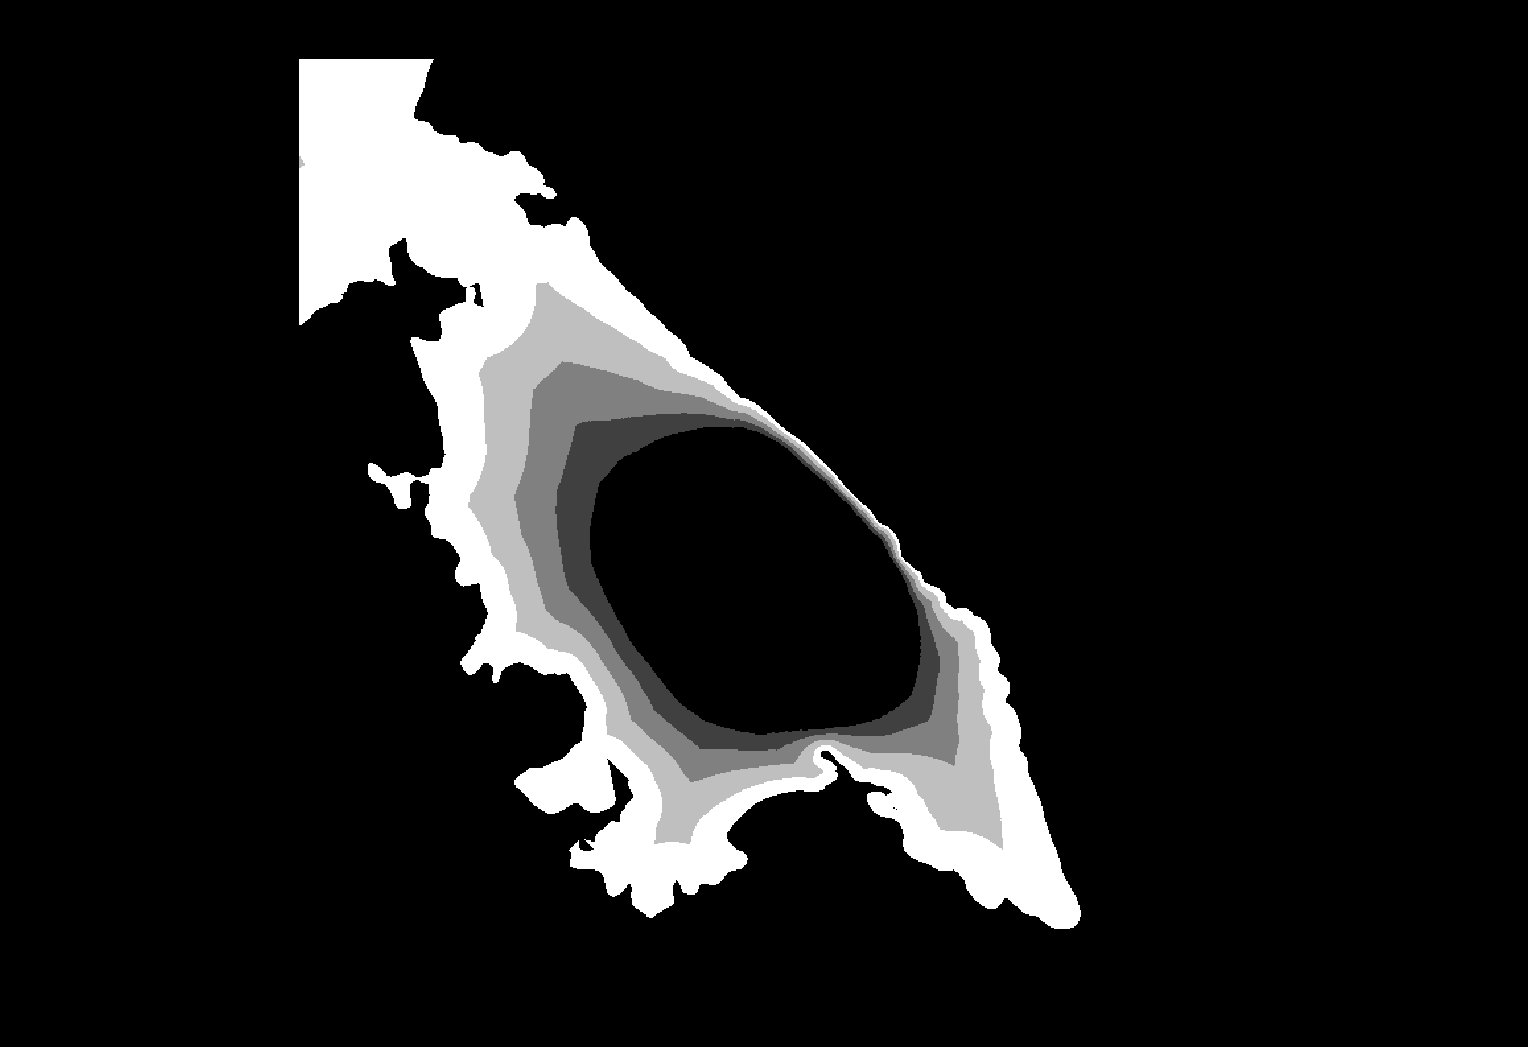

In [33]:
test_bin_indexes = (test_normalized_distance * test_bin_count).astype(int)
test_bin_indexes[test_bin_indexes > test_bin_count] = test_bin_count

viewer.add_image(test_bin_indexes)
nbscreenshot(viewer, canvas_only=True)

#### 3b. collect information from each bin

In [38]:
test_labels_and_bins = (test_good_labels - 1, test_bin_indexes[test_good_mask])

test_nobjects = 1 # to define there is only one cell being measured from I think

# get count of voxels in each bin from the following images
test_histogram_cmsk = coo_matrix( (test_cell_proj_a[test_good_mask], test_labels_and_bins), shape=(test_nobjects, test_bin_count) ).toarray()
test_histogram_org = coo_matrix(  (test_golgi_proj_a[test_good_mask], test_labels_and_bins), shape=(test_nobjects, test_bin_count) ).toarray()

# total voxel counts for the entire cell (should be the same as the volume for each of these things)
test_sum_by_object_cmsk = np.sum(test_histogram_cmsk, 1) # flattened cellmask voxel count
test_sum_by_object_org = np.sum(test_histogram_org, 1)  # organelle voxel count

In [39]:
test_bin_indexes = (test_normalized_distance * test_bin_count).astype(int)

# get number of XY pixels in each bin
test_number_at_distance = coo_matrix(( np.ones(test_ngood_pixels), test_labels_and_bins), (test_nobjects, test_bin_count)).toarray()

# total pixels in XY cell area 
test_sum_by_object = np.sum(test_number_at_distance, 1)

# get the proportion of pixels in each bin (*100 to get percentage of cell pixels per bin)
test_sum_by_object_per_bin = np.dstack([test_sum_by_object] * (test_bin_count))[0]
test_fraction_at_bin = test_number_at_distance / test_sum_by_object_per_bin

#### 3c. Create even wedges from center of centering object to measure distribution within each bin

In [44]:
# getting radial index for each pixel to create 8 wedges from center of centering object
test_i, test_j = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]] # intensity gradients of pixels in X (top to bottom) and then Y (left to right)
test_imask = test_i[test_good_mask] > test_i_center[test_good_mask]
test_jmask = test_j[test_good_mask] > test_j_center[test_good_mask]
test_absmask = abs(test_i[test_good_mask] - test_i_center[test_good_mask]) > abs(test_j[test_good_mask] - test_j_center[test_good_mask])
test_radial_index = (test_imask.astype(int) + test_jmask.astype(int) * 2 + test_absmask.astype(int) * 4)

test_radial_index_vis = np.zeros_like(test_good_mask, dtype=int)
test_radial_index_vis[test_good_mask] = test_radial_index

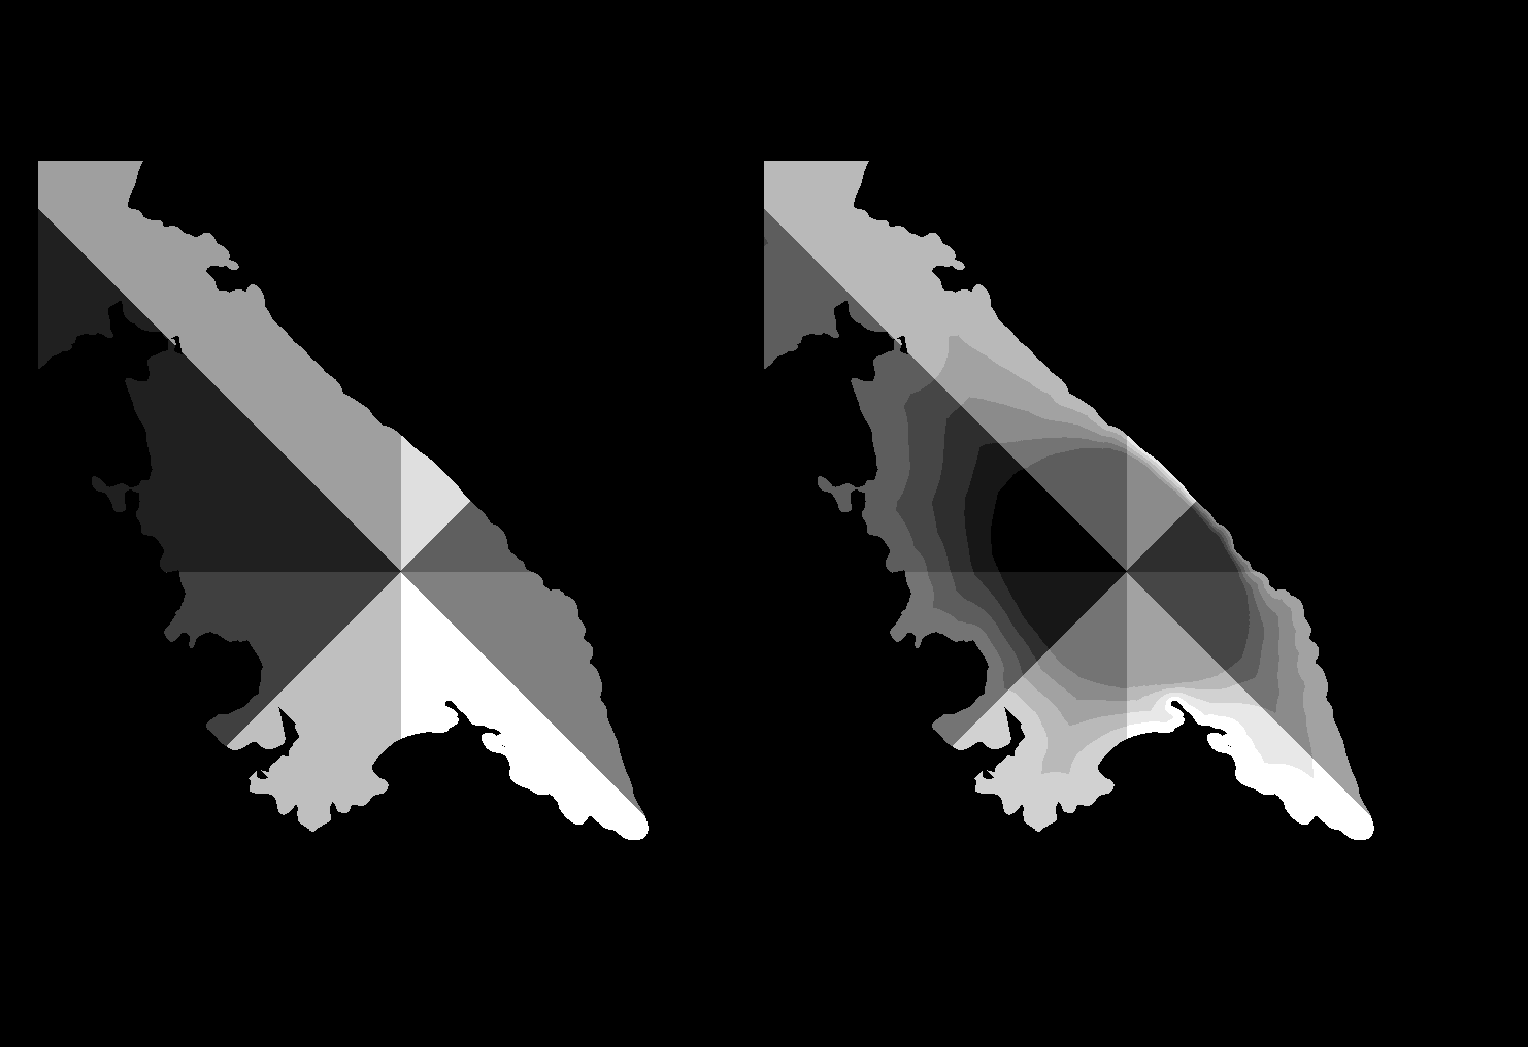

In [56]:
viewer.layers.clear()
viewer.grid.enabled = True
viewer.add_image(test_radial_index_vis + test_bin_indexes)
viewer.add_image(test_radial_index_vis + test_good_mask)

viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

#### 3d. Summarize the distribution data into one table

In [57]:
# collecting all of the information above into one place:
test_statistics = []
test_stat_names =[]
test_cv_cmsk = []
test_cv_obj = []
test_cv_img = []

for bin in range(test_bin_count):
    test_bin_mask = test_good_mask & (test_bin_indexes == bin)
    test_bin_pixels = np.sum(test_bin_mask)

    test_bin_labels = test_labels[test_bin_mask]

    test_bin_radial_index = test_radial_index[test_bin_indexes[test_good_mask] == bin]
    test_labels_and_radii = (test_bin_labels - 1, test_bin_radial_index)
    test_pixel_count = coo_matrix( (np.ones(test_bin_pixels), test_labels_and_radii), (test_nobjects, 8) ).toarray()

    test_radial_counts_cmsk = coo_matrix( (test_cell_proj_a[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray()
    test_radial_counts = coo_matrix( (test_golgi_proj_a[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray()

    # we might need the masked arrays for some organelles... but I think not. keeping for now
    test_mask = test_pixel_count == 0

    test_radial_means_cmsk = np.ma.masked_array(test_radial_counts_cmsk / test_pixel_count, test_mask)
    test_radial_cv_cmsk = np.std(test_radial_means_cmsk, 1) / np.mean(test_radial_means_cmsk, 1)
    test_radial_cv_cmsk[np.sum(~test_mask, 1) == 0] = 0
    test_radial_cv_cmsk.mask = np.sum(~test_mask, 1) == 0


    test_radial_means_obj = np.ma.masked_array(test_radial_counts / test_pixel_count, test_mask)
    test_radial_cv_obj = np.std(test_radial_means_obj, 1) / np.mean(test_radial_means_obj, 1)
    test_radial_cv_obj[np.sum(~test_mask, 1) == 0] = 0
    test_radial_cv_obj.mask = np.sum(~test_mask, 1) == 0

    test_bin_name = str(bin + 1) if bin > 0 else "1"

    test_stat_names.append(test_bin_name)
    test_cv_cmsk.append(float(np.mean(test_radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
    test_cv_obj.append(float(np.mean(test_radial_cv_obj)))

In [74]:
test_org_name = 'golgi'

test_stats_dict={'object': test_org_name,
                 'XY_n_bins': test_bin_count,
                 'XY_bins': [test_stat_names],
                 'XY_cm_vox_cnt': [test_histogram_cmsk.squeeze().tolist()],
                 'XY_org_vox_cnt': [test_histogram_org.squeeze().tolist()],
                 'XY_n_pix': [test_number_at_distance.squeeze().tolist()],
                 'XY_cm_cv':[test_cv_cmsk],
                 'XY_org_cv':[test_cv_obj]}

test_stat_tab = pd.DataFrame(test_stats_dict)

if scale is not None:
    round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
    test_stat_tab.insert(loc=1, column="scale", value=f"{round_scale}")

    test_stat_tab['XY_cm_vol'] = [(test_histogram_cmsk * np.prod(scale)).squeeze()]
    test_stat_tab['XY_org_vol'] = [(test_histogram_org * np.prod(scale)).squeeze()]
    test_stat_tab['XY_n_area'] =  [(test_number_at_distance * np.prod(scale[1:])).squeeze()]

    test_stat_tab = test_stat_tab.reindex(columns=['object', 'scale', 'XY_n_bins', 'XY_bins', 'XY_cm_vox_cnt',
       'XY_org_vox_cnt', 'XY_n_pix', 'XY_cm_vol', 'XY_org_vol', 'XY_n_area', 'XY_cm_cv', 'XY_org_cv'])

else: 
    test_stat_tab.insert(loc=2, column="scale", value=f"{tuple(np.ones(3))}")


In [75]:
test_stat_tab

,object,scale,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_vol,XY_org_vol,XY_n_area,XY_cm_cv,XY_org_cv
0,golgi,"(0.3891, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[1660.7031809280143, 369.34000217395953, 486.1...","[7.303144042717942, 23.07863023968345, 18.7617...","[274.62388814338397, 70.61447263192522, 100.04...","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042..."


#### Define `get_concentric_distribution()` function

Based on the *prototyping* above, define the function to create a specific number of bins and measure object distribution within them.

In [78]:
def _get_concentric_distribution(
        cellmask_proj: np.ndarray,
        nucleus_proj: np.ndarray,
        org_proj: np.ndarray,
        org_name: str,
        scale: Union[tuple, None]=None,
        bin_count: Union[int, None] = 5,
        center_obj_as_bin: bool = True,
        bins_from_center:bool = False
    ):
    """
    Based on CellProfiler's measureobjectintensitydistribution. Measure the distribution of segmented objects within a masked area. 
    In our case, we will usually utilize this function to measure the amount of an organelle within the cell.
    Radial bins are created out from a center point, usually the nucleus edge.

    Parameters
    ------------
    cellmask_proj: np.ndarray
        a sum projection of the segmented cell area where the "intensity" value of each pixel is equal to the number of z slices where the binary cell mask is True
    nucleus_proj: np.ndarray
        a sum projection of the segmented nucleus area where the "intensity" value of each pixel is equal to the number of z slices where the binary nucleus mask is True
    org_proj: np.ndarray,
        a sum projection of the segmented organelle area where the "intensity" value of each pixel is equal to the number of z slices where the binary organelle mask is True
    org_name: str,
        the name or nickname of your organelle; used for labeling columns in the dataframe
    bin_count: Union[int, None] = 5,
        the number of bins to create within the cell mask
    center_obj_as_bin: bool = True,
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins
    bins_from_center:bool = False
        True = distribute the bins from the center of the centering object
    masked


    Returns
    -------------
    returns one statistics table (pd.DataFrame) + bin_array (np.ndarray) image
    """

    # other parameters that will stay constant
    nobjects = 1

    # create binary arrays
    center_objects = nucleus_proj>0 
    cellmask = (cellmask_proj>0).astype(np.uint16)


    ################   ################
    ## define masks for computing distances
    ################   ################
    normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(cellmask, center_objects, bins_from_center, center_obj_as_bin)
    
    if normalized_distance is None:
        print('WTF!!  normalized_distance returned wrong')

    ################   ################
    ## get histograms
    ################   ################
    ngood_pixels = np.sum(good_mask)
    good_labels = cellmask[good_mask]

    # protect against None normaized_distances
    bin_array = (normalized_distance * bin_count).astype(int)
    bin_array[bin_array > bin_count] = bin_count # shouldn't do anything

    #                 (    i          ,         j              )
    labels_and_bins = (good_labels - 1, bin_array[good_mask])

    #                coo_matrix( (             data,             (i, j)    ), shape=                      )
    histogram_cmsk = coo_matrix( (cellmask_proj[good_mask], labels_and_bins), shape=(nobjects, bin_count) ).toarray()
    histogram_org = coo_matrix(  (org_proj[good_mask],      labels_and_bins), shape=(nobjects, bin_count) ).toarray()

    bin_array = (normalized_distance * bin_count).astype(int)

    sum_by_object_cmsk = np.sum(histogram_cmsk, 1) # flattened cellmask voxel count
    sum_by_object_org = np.sum(histogram_org, 1)  # organelle voxel count


    # DEPRICATE: since we are NOT computing object_i by object_i (individual organelle labels)
    # sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count + 1))[0]
    # fraction_at_distance = histogram / sum_by_object_per_bin

    # number of bins.
    number_at_distance = coo_matrix(( np.ones(ngood_pixels), labels_and_bins), (nobjects, bin_count)).toarray()

    # sicne we aren't breaking objects apart this is just ngood_pixels

    sum_by_object = np.sum(number_at_distance, 1)

    sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count))[0]
    fraction_at_bin = number_at_distance / sum_by_object_per_bin # sums to 1.0

    # object_mask = number_at_distance > 0
    # DEPRICATE:# not doing over multiple objects so don't need object mask.. or fractionals
    # mean_pixel_fraction = fraction_at_distance / ( fraction_at_bin + np.finfo(float).eps )
    # masked_fraction_at_distance = np.ma.masked_array( fraction_at_distance, ~object_mask )
    # masked_mean_pixel_fraction = np.ma.masked_array(mean_pixel_fraction, ~object_mask)

    ################   ################
    ## collect Anisotropy calculation.  + summarize
    ################   ################
    # Split each cell into eight wedges, then compute coefficient of variation of the wedges' mean intensities
    # in each ring. Compute each pixel's delta from the center object's centroid
    i, j = np.mgrid[0 : cellmask.shape[0], 0 : cellmask.shape[1]]
    imask = i[good_mask] > i_center[good_mask]
    jmask = j[good_mask] > j_center[good_mask]
    absmask = abs(i[good_mask] - i_center[good_mask]) > abs(j[good_mask] - j_center[good_mask])
    radial_index = (imask.astype(int) + jmask.astype(int) * 2 + absmask.astype(int) * 4)

    wedge_array = np.zeros_like(good_mask, dtype=int)
    wedge_array[good_mask] = radial_index

    # return radial_index, labels, good_mask, bin_indexes
    stat_names =[]
    cv_cmsk = []
    cv_obj = []

    # collect the numbers from each "bin"
    for bin in range(bin_count):
        bin_mask = good_mask & (bin_array == bin)
        bin_pixels = np.sum(bin_mask)

        bin_labels = cellmask[bin_mask]

        bin_radial_index = radial_index[bin_array[good_mask] == bin]
        labels_and_radii = (bin_labels - 1, bin_radial_index)
        pixel_count = coo_matrix( (np.ones(bin_pixels), labels_and_radii), (nobjects, 8) ).toarray()

        radial_counts_cmsk = coo_matrix( (cellmask_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        radial_counts = coo_matrix( (org_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        # radial_values = coo_matrix( (img_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()

        # we might need the masked arrays for some organelles... but I think not. keeping for now
        mask = pixel_count == 0

        radial_means_cmsk = np.ma.masked_array(radial_counts_cmsk / pixel_count, mask)
        radial_cv_cmsk = np.std(radial_means_cmsk, 1) / np.mean(radial_means_cmsk, 1)
        radial_cv_cmsk[np.sum(~mask, 1) == 0] = 0
        radial_cv_cmsk.mask = np.sum(~mask, 1) == 0


        radial_means_obj = np.ma.masked_array(radial_counts / pixel_count, mask)
        radial_cv_obj = np.std(radial_means_obj, 1) / np.mean(radial_means_obj, 1)
        radial_cv_obj[np.sum(~mask, 1) == 0] = 0
        radial_cv_obj.mask = np.sum(~mask, 1) == 0

        bin_name = str(bin + 1) if bin > 0 else "1"

        stat_names.append(bin_name)
        cv_cmsk.append(float(np.mean(radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
        cv_obj.append(float(np.mean(radial_cv_obj)))
    
    stats_dict={'object': org_name,
                'XY_n_bins': bin_count,
                'XY_bins': [stat_names],
                'XY_cm_vox_cnt': [histogram_cmsk.squeeze().tolist()],
                'XY_org_vox_cnt': [histogram_org.squeeze().tolist()],
                'XY_n_pix': [number_at_distance.squeeze().tolist()],
                'XY_cm_cv':[cv_cmsk],
                'XY_org_cv':[cv_obj]}

    # stats_tab = pd.DataFrame(statistics,columns=col_names)
    stats_tab = pd.DataFrame(stats_dict)  

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        stats_tab.insert(loc=1, column="scale", value=f"{round_scale}")

        stats_tab['XY_cm_vol'] = [(histogram_cmsk * np.prod(scale)).squeeze()]
        stats_tab['XY_org_vol'] = [(histogram_org * np.prod(scale)).squeeze()]
        stats_tab['XY_n_area'] =  [(number_at_distance * np.prod(scale[1:])).squeeze()]

        stats_tab = stats_tab.reindex(columns=['object', 'scale', 'XY_n_bins', 'XY_bins', 'XY_cm_vox_cnt',
        'XY_org_vox_cnt', 'XY_n_pix', 'XY_cm_vol', 'XY_org_vol', 'XY_n_area', 'XY_cm_cv', 'XY_org_cv'])

    else: 
        stats_tab.insert(loc=2, column="scale", value=f"{tuple(np.ones(3))}")

    return stats_tab, bin_array, wedge_array

In [79]:
test_stats_tab_a, test_bin_indexes_a, test_wedge_indexes_a = _get_concentric_distribution(cellmask_proj=test_cell_proj_a, 
                                                                                            nucleus_proj=test_nuc_proj_a, 
                                                                                            org_proj=test_golgi_proj_a, 
                                                                                            org_name='golgi', 
                                                                                            scale=scale,
                                                                                            bin_count=5, 
                                                                                            center_obj_as_bin=True,
                                                                                            bins_from_center=False)

test_stats_tab_a

,object,scale,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_vol,XY_org_vol,XY_n_area,XY_cm_cv,XY_org_cv
0,golgi,"(0.3891, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[1660.7031809280143, 369.34000217395953, 486.1...","[7.303144042717942, 23.07863023968345, 18.7617...","[274.62388814338397, 70.61447263192522, 100.04...","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042..."


In [82]:
test_stats_tab_a.equals(test_stat_tab)

True

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requeste

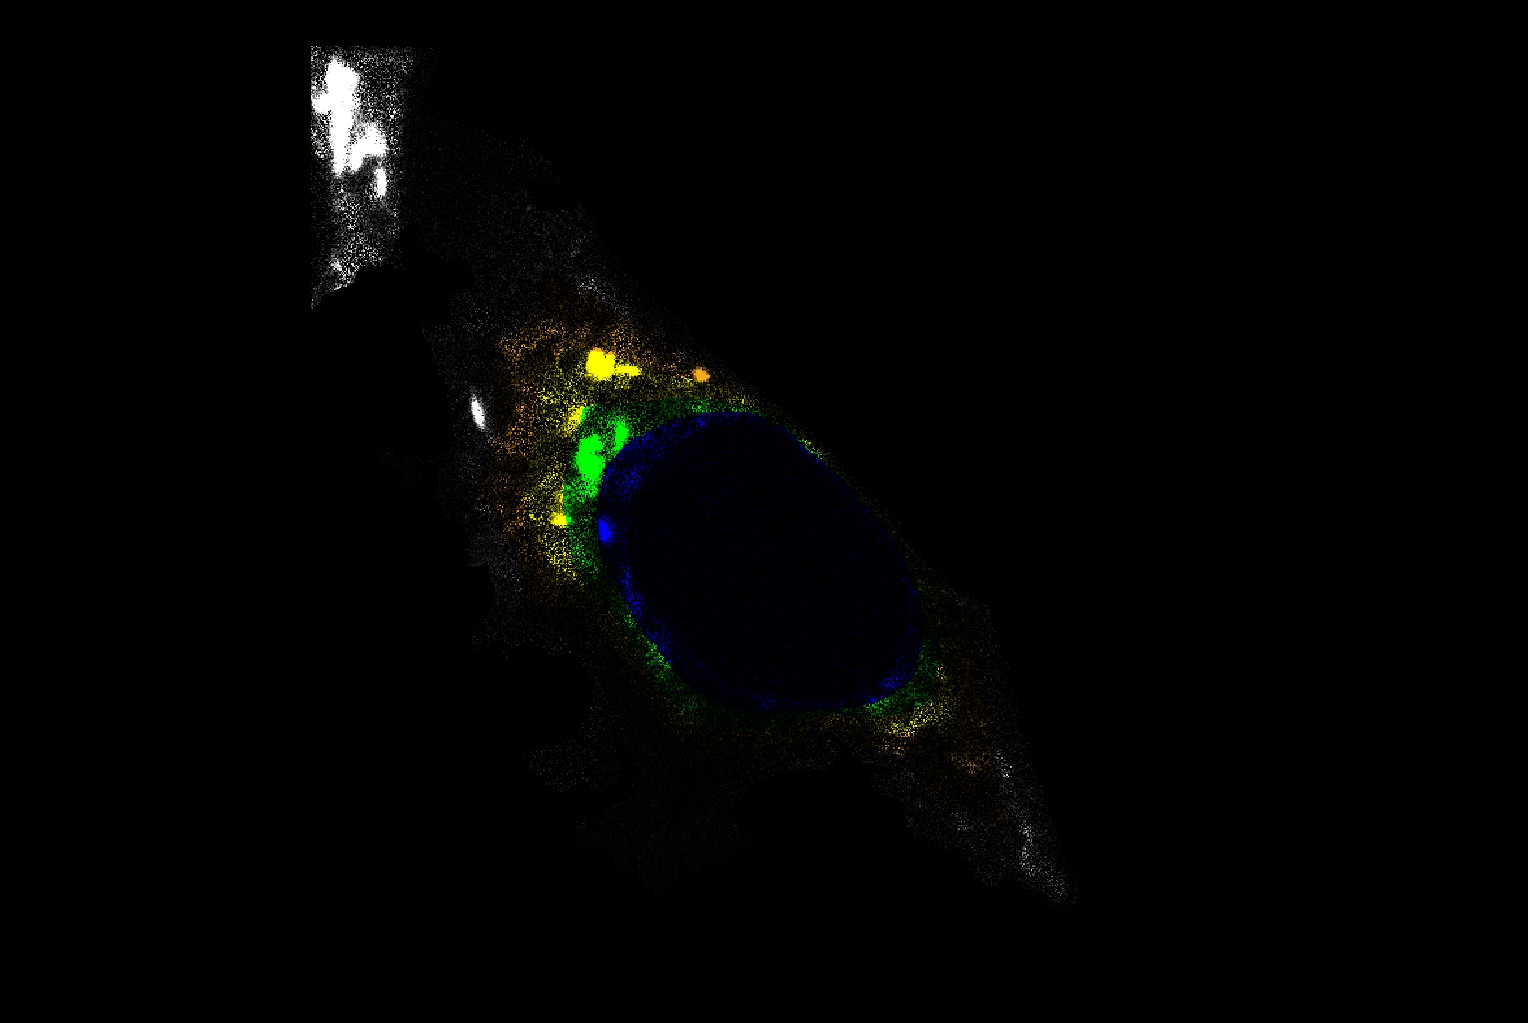

In [85]:
# visualization of organelles within bins and wedges 
fourdim_bins = []
for bin in range(test_bin_count):
    bin_image_2d = test_bin_indexes_a == bin
    bin_image_2d = apply_mask(bin_image_2d, test_good_mask)
    bin_image_4d = np.tile(bin_image_2d, (raw_img_data.shape[0], raw_img_data.shape[1],1,1))
    fourdim_bins.append(bin_image_4d)
fourdim_bins = np.array(fourdim_bins)

viewer.layers.clear()

colors = ["blue","green","yellow","bop orange","gray"]
for bin in range(test_bin_count):
    viewer.add_image(raw_img_data[3] * fourdim_bins[bin][5],
                        colormap=colors[bin],
                        blending="additive",
                        scale=scale,contrast_limits=([0, 10000]),
                        rotate = (5, 5, 0))

viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

In [128]:
viewer.close()

#### Add prototype function into `stats.py`

In [88]:
from infer_subc.utils.stats import get_concentric_distribution

test_stats_tab_final, bin_image_final, wedge_image_final = get_concentric_distribution(cellmask_proj=test_cell_proj_a, 
                                                                                        nucleus_proj=test_nuc_proj_a, 
                                                                                        org_proj=test_golgi_proj_a, 
                                                                                        org_name='golgi', 
                                                                                        scale=scale,
                                                                                        bin_count=5, 
                                                                                        center_obj_as_bin=True,
                                                                                        bins_from_center=False)

test_stats_tab_a.equals(test_stats_tab_final)

True

In [89]:
test_stats_tab_final

,object,scale,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_vol,XY_org_vol,XY_n_area,XY_cm_cv,XY_org_cv
0,golgi,"(0.3891, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[1660.7031809280143, 369.34000217395953, 486.1...","[7.303144042717942, 23.07863023968345, 18.7617...","[274.62388814338397, 70.61447263192522, 100.04...","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042..."


### 4. Collect measurement about the distribution the organelles within each bin using zernike features

#### 4a. Specify the number of degress to use for calculating zernike features

In [90]:
test_labels = label(test_cell_proj_a>0)

# get the zernike indexes based on the number of degrees chosen
test_zernike_degree = 9
test_zernike_indexes = centrosome.zernike.get_zernike_indexes( test_zernike_degree + 1)

In [91]:
# get the center of the cell mask and the radius of the minimum enclosed circle
test_ij, test_r = centrosome.cpmorphology.minimum_enclosing_circle( test_labels )

# create a gradient of intensities in X and Y
test_iii, test_jjj = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]]

# normalize those values using the center of the cell and radius calculated above
test_iii = (test_iii-test_ij[0][0] ) / test_r
test_jjj = (test_jjj-test_ij[0][1] ) / test_r

# create the zernike polynomials
test_z = centrosome.zernike.construct_zernike_polynomials(test_iii, test_jjj, test_zernike_indexes)

#### Define `zernike_polynomial()` function

Based on the prototyping above, define the function to create zernike polynomials

In [92]:
def _zernike_polynomial(labels, zernike_is):
    """
    

    """
    # First, get a table of centers and radii of minimum enclosing
    # circles for the cellmask
    ij, r = centrosome.cpmorphology.minimum_enclosing_circle( labels )
    # Then compute x and y, the position of each labeled pixel
    # within a unit circle around the object
    iii, jjj = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]

    # translate+scale
    iii = (iii-ij[0][0] ) / r
    jjj = (jjj-ij[0][1] ) / r

    z = centrosome.zernike.construct_zernike_polynomials(
        iii, jjj, zernike_is
    )
    return z

In [93]:
test_z_a = _zernike_polynomial(test_labels, test_zernike_indexes)

np.array_equal(test_z, test_z_a)

True

#### Add the prototype function into `stats.py`

In [94]:
from infer_subc.utils.stats import zernike_polynomial

test_z_final = zernike_polynomial(test_labels, test_zernike_indexes)

np.array_equal(test_z, test_z_final)

True

#### 4b. collect zernike measurements

In [95]:
# collecting zernike measurements for golgi example
test_vr = np.sum(test_golgi_proj_a[:,:,np.newaxis]*test_z.real, axis=(0,1))
test_vi = np.sum(test_golgi_proj_a[:,:,np.newaxis]*test_z.imag, axis=(0,1))    
test_magnitude = np.sqrt(test_vr * test_vr + test_vi * test_vi) / test_golgi_proj.sum()
test_phase = np.arctan2(test_vr, test_vi)

#### Define `zernike_stat()` function

Based on the prototyping above, defin the function to quantify zernike features for each bin.

In [96]:
def _zernike_metrics(pixels, z):
    """
    
    """
    vr = np.sum(pixels[:,:,np.newaxis]*z.real, axis=(0,1))
    vi = np.sum(pixels[:,:,np.newaxis]*z.imag, axis=(0,1))    
    magnitude = np.sqrt(vr * vr + vi * vi) / pixels.sum()
    phase = np.arctan2(vr, vi)
    return magnitude, phase

In [97]:
# collecting zernike measurements for cell and nucleus too
test_z_cm = _zernike_metrics(test_cell_proj_a, test_z)
test_z_nuc = _zernike_metrics(test_nuc_proj_a, test_z)
test_z_golgi = _zernike_metrics(test_golgi_proj_a, test_z)

In [98]:
np.array_equal(test_z_golgi[0], test_magnitude), np.array_equal(test_z_golgi[1], test_phase)

(True, True)

#### Add the function to `stats.py`

In [99]:
from infer_subc.utils.stats import zernike_metrics

test_z_golgi_final = zernike_metrics(test_golgi_proj_a, test_z)

np.array_equal(test_z_golgi, test_z_golgi_final)

True

#### 4c. Summarize the data in a data table

In [100]:
# nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
test_z_stats_tab = pd.DataFrame({'object':'golgi',
                            'zernike_n':[test_zernike_indexes[:,0].tolist()],
                            'zernike_m':[test_zernike_indexes[:,1].tolist()],
                            'zernike_cm_mag':[test_z_cm[0].tolist()],
                            'zernike_cm_phs':[test_z_cm[1].tolist()],   
                            'zernike_obj_mag':[test_z_golgi_final[0].tolist()],
                            'zernike_obj_phs':[test_z_golgi_final[1].tolist()],
                            'zernike_nuc_mag':[test_z_nuc[0].tolist()],
                            'zernike_nuc_phs':[test_z_nuc[1].tolist()]})

test_z_stats_tab

,object,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs
0,golgi,"[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57..."


#### Define `get_zernike_metics()` function

Based on the prototyping above, defin the function to quantify and summarize the zernike features

In [101]:
def _get_zernike_metrics(        
        cellmask_proj: np.ndarray,
        nucleus_proj: Union[np.ndarray, None], 
        org_proj: np.ndarray,
        organelle_name: str,
        zernike_degree: int = 9 ):

    """
    
    """

    labels = label(cellmask_proj>0) #extent as 0,1 rather than bool
    zernike_indexes = centrosome.zernike.get_zernike_indexes( zernike_degree + 1)


    z = zernike_polynomial(labels, zernike_indexes)

    z_cm = zernike_metrics(cellmask_proj, z)
    z_org = zernike_metrics(org_proj, z)
    z_nuc = zernike_metrics(nucleus_proj, z)



    # nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
    stats_tab = pd.DataFrame({'object':organelle_name,
                                'zernike_n':[zernike_indexes[:,0].tolist()],
                                'zernike_m':[zernike_indexes[:,1].tolist()],
                                'zernike_cm_mag':[z_cm[0].tolist()],
                                'zernike_cm_phs':[z_cm[1].tolist()],   
                                'zernike_obj_mag':[z_org[0].tolist()],
                                'zernike_obj_phs':[z_org[1].tolist()],
                                'zernike_nuc_mag':[z_nuc[0].tolist()],
                                'zernike_nuc_phs':[z_nuc[1].tolist()]})

    return stats_tab

In [102]:
test_z_stats_tab_a = _get_zernike_metrics(test_cell_proj_a, test_nuc_proj_a, test_golgi_proj_a, 'golgi', 9)

In [103]:
test_z_stats_tab.equals(test_z_stats_tab_a)

True

#### Add function to `stats.py`

In [106]:
from infer_subc.utils.stats import get_zernike_metrics

test_z_stats_tab_final = get_zernike_metrics(test_cell_proj_a, test_nuc_proj_a, test_golgi_proj_a, 'golgi', 9)

test_z_stats_tab_final.equals(test_z_stats_tab_a)

True

In [107]:
test_z_stats_tab_final

,object,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs
0,golgi,"[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57..."


#### Combine XY_distirbution and zernike measurements into one dataframe

In [116]:
test_combined_tab = pd.merge(test_stats_tab_final, test_z_stats_tab_final, on="object")

test_combined_tab

,object,scale,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_vol,XY_org_vol,XY_n_area,XY_cm_cv,XY_org_cv,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs
0,golgi,"(0.3891, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[1660.7031809280143, 369.34000217395953, 486.1...","[7.303144042717942, 23.07863023968345, 18.7617...","[274.62388814338397, 70.61447263192522, 100.04...","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57..."


### Define `get_XY_dist_metrics()` function

Based on the prototyping above, define the function to create the sum projections, create the normalized bins from centering object out to the edge of the cell, measure the distribution in the cell, and the zernike distribution within the bins.

In [117]:
def _get_XY_dist_metrics(        
        cellmask_obj: np.ndarray,
        nuclei_obj: np.ndarray,
        organelle_obj:np.ndarray,
        organelle_name: str,
        scale: Union[tuple, None]=None,
        num_bins: Union[int,None] = None,
        center_obj_as_bin=True,
        bins_from_center=False,
        zernike_degrees: Union[int,None] = None,
        ):

    """
    Params
    ----------



    Returns
    -----------
    rstats table of radial distributions
    zstats table of zernike magnitudes and phases
    rad_bins image of the rstats bins over the cellmask_obj 

    """

    cell_proj = create_masked_sum_projection(cellmask_obj)
    nucleus_proj = create_masked_sum_projection(nuclei_obj,cellmask_obj.astype(bool))
    org_proj = create_masked_sum_projection(organelle_obj,cellmask_obj.astype(bool))
 

    XY_metrics, dist_bin_mask, dist_wedge_mask = get_concentric_distribution(cellmask_proj=cell_proj, 
                                                        nucleus_proj=nucleus_proj, 
                                                        org_proj=org_proj, 
                                                        org_name=organelle_name, 
                                                        scale=scale,
                                                        bin_count=num_bins, 
                                                        center_obj_as_bin=center_obj_as_bin,
                                                        bins_from_center=bins_from_center)
    
    if zernike_degrees is not None:
        zernike_metrics = get_zernike_metrics(cellmask_proj=cell_proj, 
                                            org_proj=org_proj,
                                            organelle_name=organelle_name, 
                                            nucleus_proj=nucleus_proj, 
                                            zernike_degree=zernike_degrees)
        
        XY_metrics = pd.merge(XY_metrics, zernike_metrics, on="object")

    return XY_metrics, dist_bin_mask, dist_wedge_mask 

In [120]:
test_XY_metrics, test_dist_bins, test_dist_wedges = _get_XY_dist_metrics(cell_seg,
                                                                        nuc_seg,
                                                                        golgi_seg,
                                                                        'golgi',
                                                                        scale,
                                                                        5,
                                                                        True,
                                                                        False,
                                                                        9)

In [122]:
test_XY_metrics.equals(test_combined_tab), np.array_equal(test_dist_bins, test_bin_indexes_a), np.array_equal(test_dist_wedges, test_radial_index_vis)

(True, True, True)

### Add function to `stats.py`

In [127]:
from infer_subc.utils.stats import get_XY_distribution

test_XY_metrics_final, test_dist_bins_final, test_dist_wedges_final = get_XY_distribution(cell_seg,
                                                                        nuc_seg,
                                                                        golgi_seg,
                                                                        'golgi',
                                                                        scale,
                                                                        5,
                                                                        True,
                                                                        False,
                                                                        9)

test_XY_metrics_final.equals(test_combined_tab), np.array_equal(test_dist_bins, test_dist_bins_final), np.array_equal(test_dist_wedges, test_dist_wedges_final)

(True, True, True)

__________________________
## Z Distribution 
Segment image in 3D;
measure area fraction of each organelle per Z slice;
these measurements will act as a frequency distribution of that organelle starting from the bottom of the cellmask (not including neurites) to the top of the cellmask;
measurements: mean, median, and standard deviation of the frequency distribution	

- pre-processing
  1. subtract nuclei from the cellmask --> cellmask cytoplasm
  2. mask organelle channels with cellmask cytoplasm mask

- per-object measurements
  - For each Z slice in the masked binary image measure:
    1. organelle area
    2. cellmask cytoplasm area

- per-object calculations
  - For each Z slice in the masked binary image: organelle area / cellmask cytoplasm area

- per cell summary
  1. create a frequency table with the z slice number on the x axis and the area fraction on the y axis
  2. Measure the frequency distribution's mean, median, and standard deviation for each cell"

### 1. Sum all True pixels in each Z slices (olong the X and Y axes)

In [ ]:
raw_img_data.shape

(8, 17, 704, 704)

In [ ]:
test_golgi_for_Zdist = golgi_seg.astype(bool)

test_golgi_for_Zdist_masked = apply_mask(test_golgi_for_Zdist, cell_seg)

test_golgi_for_Zdist_masked.shape

(17, 704, 704)

In [ ]:
test_golgi_Zdist = test_golgi_for_Zdist_masked.sum(axis=(1,2))
test_golgi_Zdist.shape, test_golgi_Zdist

((17,),
 array([ 141,  221,  393, 1044, 1825, 2022, 1859, 1192, 1364, 1400, 1958,
        2392, 2200, 1609,  899,    0,    0]))

### Define `create_masked_depth_projection()` function

Based on the prototyping above, sum the True values along XY for every Z slice

In [ ]:
def _create_masked_depth_projection(img_in:np.ndarray, mask:Union[np.ndarray, None]=None, to_bool:bool=True) -> np.ndarray:
    """
    create masked projection onto the Z dimension
    """
    img_out = img_in.astype(bool) if to_bool else img_in
    if mask is not None:
        img_out = apply_mask(img_out, mask)
    
    return img_out.sum(axis=(1,2))

In [ ]:
golgi_Zdist_final = _create_masked_depth_projection(golgi_seg, cell_seg)
cell_Zdist_final = _create_masked_depth_projection(cell_seg)
nuc_Zdist_final = _create_masked_depth_projection(nuc_seg, cell_seg)

np.array_equal(test_golgi_Zdist, golgi_Zdist_final)

True

### Add function to `stats.py`

In [ ]:
from infer_subc.utils.stats import create_masked_depth_projection

golgi_Zdist_final_a = create_masked_depth_projection(golgi_seg, cell_seg)

np.array_equal(golgi_Zdist_final_a, golgi_Zdist_final)

True

### 2. List the bins and summarize the data

In [ ]:
# list the "bins" which in this case as the z-slices
test_z_bins = [i for i in range(cell_seg.shape[0])]
test_z_bins

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
# summarize the Z distribution data in a table
organelle_name = 'golgi'
test_zdist_stats_tab = pd.DataFrame({'organelle':organelle_name,
                        'z_n':cell_seg.shape[0],
                        'z_slice':[test_z_bins],
                        'z_cm_vox_cnt':[cell_Zdist_final.tolist()],
                        "z_org_vox_cnt":[golgi_Zdist_final.tolist()],
                        'z_nuc_vox_cnt':[nuc_Zdist_final.tolist()]})

test_zdist_stats_tab

,organelle,z_n,z_slice,z_cm_vox_cnt,z_org_vox_cnt,z_nuc_vox_cnt
0,golgi,17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[141, 221, 393, 1044, 1825, 2022, 1859, 1192, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."


### Define `get_Z_dist_metrics()` function

Based on the prototyping above, create projections along XY for each Z slice and sum the True pixels.

In [ ]:
def _get_Z_dist_metrics(        
        cellmask_obj: np.ndarray,
        organelle_obj:np.ndarray,
        organelle_name: str,
        nuclei_obj: Union[np.ndarray, None],
        ):
    """

    """

    # flattened
    cellmask_proj = create_masked_depth_projection(cellmask_obj)
    org_proj = create_masked_depth_projection(organelle_obj,cellmask_obj.astype(bool))

    nucleus_proj = create_masked_depth_projection(nuclei_obj,cellmask_obj.astype(bool)) if nuclei_obj is not None else None
    z_bins = [i for i in range(cellmask_obj.shape[0])]

    stats_tab = pd.DataFrame({'organelle':organelle_name,
                            'z_n':cellmask_obj.shape[0],
                            'z_slice':[z_bins],
                            'z_cm_vox_cnt':[cellmask_proj.tolist()],
                            'z_org_vox_cnt':[org_proj.tolist()],
                            'z_nuc_vox_cnt':[nucleus_proj.tolist()]})
    return stats_tab

In [ ]:
zdist_stats_tab_final = _get_Z_dist_metrics(cellmask_obj=cell_seg, organelle_name='golgi', organelle_obj=golgi_seg, nuclei_obj=nuc_seg)

In [ ]:
test_zdist_stats_tab.equals(zdist_stats_tab_final)

True

### Add function to `stats.py`

In [ ]:
from infer_subc.utils.stats import get_Z_dist_metrics

zdist_stats_tab_final_a = get_Z_dist_metrics(cellmask_obj=cell_seg, organelle_name='golgi', organelle_obj=golgi_seg, nuclei_obj=nuc_seg)

zdist_stats_tab_final_a.equals(zdist_stats_tab_final)

True

In [ ]:
zdist_stats_tab_final_a

,organelle,z_n,z_slice,z_cm_vox_cnt,z_org_vox_cnt,z_nuc_vox_cnt
0,golgi,17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[141, 221, 393, 1044, 1825, 2022, 1859, 1192, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
